In [1]:
import torch
from functions.thresholding import *
import numpy as np
from functions.MAE import create_dataset, create_dataloader, train_model
from functions.dataloader import load_threshold, load_torque
import matplotlib.pyplot as plt
import pickle as pkl
from functions.MAE import create_Vanilla_MAE
import random
from functions.curveadaptations import *
from functions.dataloader import load_torque
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\LocalData\Anaconda3-2020-07\envs\clean\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 100/100 [35:57<00:00, 21.57s/it]


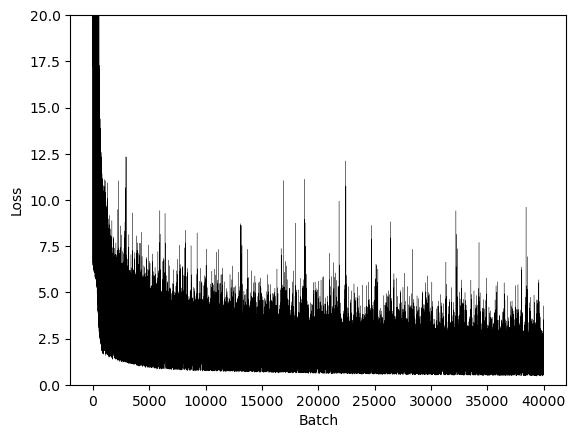

In [2]:
n_tasks = 16
alpha = 0.1
combinations = pkl.load(open(f"evaluation_data\Test_combinations_{n_tasks}.pkl","rb"))
test_dataset = pkl.load(open(f"evaluation_data\Test_data_{n_tasks}_100.pkl", "rb"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eval_loss_function= torch.nn.MSELoss
optimizer = torch.optim.RAdam
train_loss_function = torch.nn.SmoothL1Loss
cols = [str(i) for i in np.arange(0,300,1)]
model = create_Vanilla_MAE(250, 300, combinations, 0, device)
ds = create_dataset(combinations, cols, path="C:\LocalData\Data\Completely_preprocessed_data")
dl = create_dataloader(ds, 64, 25)
train_model(model, 100, dl, train_loss_function, optimizer, device, 300, 0.0001)

In [3]:
def get_simulation_results(monitors, tasks, adaptations, max_anomaly_degree, normal, buildup, anomal, model, thresholds_low, thresholds_high, alternating:bool = False, alternating_frequency:int = 5, print_df:bool = True):
    false_positive_rates = {}
    recalls = {}
    reaction_times = {}
    with tqdm(total=len(monitors)*len(tasks)*len(adaptations)) as progress:
        for m in monitors:
            false_positive_rates[m] = []
            recalls[m] = []
            reaction_times[m] = []
            for t in tasks:
                for a in adaptations:
                    if m == "dynamiclow":
                        monitor = create_dynamic_monitor(combinations, model, 0.1)
                    elif m == "dynamicmedium":
                        monitor = create_dynamic_monitor(combinations, model)
                    elif m == "dynamichigh":
                        monitor = create_dynamic_monitor(combinations, model, 0.4)
                    elif m == "staticlow":
                        monitor = create_static_monitor(combinations, model, thresholds_low)
                    elif m == "statichigh":
                        monitor = create_static_monitor(combinations, model, thresholds_high)
                    elif m == "baseline":
                        monitor = create_baseline_monitor(combinations)
                    else:
                        print(f"Monitor {m} not implemented. Check spelling and implementation of the entered monitor.")
                        break
                    false_positive_rate = 0
                    recall = 0
                    reaction_time = None
                    anomalies = simulation(monitor, t, combinations, normal, buildup, anomal, a, max_anomaly_degree, alternating, alternating_frequency, False)
                    for i in range(normal):
                        if anomalies[i] == True:
                            false_positive_rate += 1/normal
                    for i in range(normal, normal+buildup):
                        if anomalies[i] == True:
                            recall = 1
                            if reaction_time == None:
                                reaction_time = i
                    for i in range(normal+buildup, normal+buildup+anomal):
                        if anomalies[i] == True:
                            recall = 1
                            if reaction_time == None:
                                reaction_time = i
                    false_positive_rates[m].append(false_positive_rate)
                    reaction_times[m].append(reaction_time)
                    recalls[m].append(recall)
                    progress.update(1)
    progress.close()
    df = pd.DataFrame(columns=['Model', 'FP rate', 'Recall', 'Reaction time'])
    for n, m in enumerate(monitors):
        fpr = round(np.mean([j for j in false_positive_rates[m] if j != None]),3)
        rt = round(np.mean([j for j in reaction_times[m] if j != None]),3)
        rc = round(np.mean([j for j in recalls[m] if j != None]),3)
        row = [m, fpr, rc, rt]
        df.loc[n] = row
    if print_df:
        print(df)
    return df

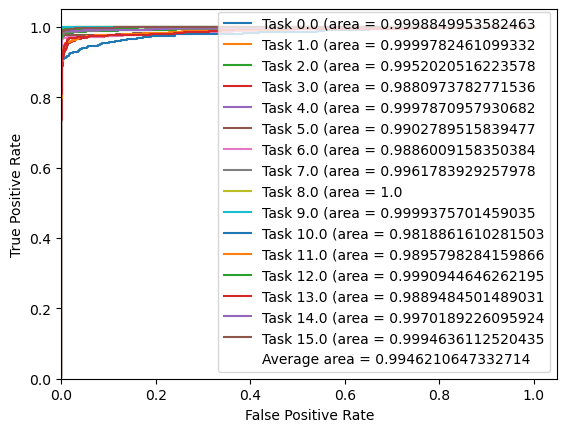

In [4]:
monitors = ["dynamic", "static", "baseline"]
tasks = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]
adaptations = ["higher peak", "add std", "widen peak", "smooth noise", "random noise", "random point", "shift curve", "reverse curve", "higher variation"]
thresholds_high = compute_thresholds(model, test_dataset, 0.05)
thresholds_low = compute_thresholds(model, test_dataset, 0.005)

In [ ]:
monitors = ["dynamiclow", "dynamicmedium", "dynamichigh", "staticlow", "statichigh", "baseline"]
tasks = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]
adaptations = ["higher peak", "add std", "widen peak", "smooth noise", "random noise", "random point", "shift curve", "reverse curve", "higher variation"]
thresholds_high = compute_thresholds(model, test_dataset, 0.05)
thresholds_low = compute_thresholds(model, test_dataset, 0.005)

In [ ]:
a = get_simulation_results(monitors, tasks, adaptations, 0.25, 100, 100, 10, model, thresholds_low, thresholds_high)
b = get_simulation_results(monitors, tasks, adaptations, 0.5, 100, 100, 10, model, thresholds_low, thresholds_high)
c = get_simulation_results(monitors, tasks, adaptations, 1, 100, 100, 10, model, thresholds_low, thresholds_high)
d = get_simulation_results(monitors, tasks, adaptations, 2, 100, 100, 10, model, thresholds_low, thresholds_high)
e = get_simulation_results(monitors, tasks, adaptations, 0.25, 100, 0, 100, model, thresholds_low, thresholds_high)
f = get_simulation_results(monitors, tasks, adaptations, 0.5, 100, 0, 100, model, thresholds_low, thresholds_high)
g = get_simulation_results(monitors, tasks, adaptations, 1, 100, 0, 100, model, thresholds_low, thresholds_high)
h = get_simulation_results(monitors, tasks, adaptations, 2, 100, 0, 100, model, thresholds_low, thresholds_high)
i = get_simulation_results(monitors, tasks, adaptations, 0.25, 100, 0, 100, model, thresholds_low, thresholds_high, True)
j = get_simulation_results(monitors, tasks, adaptations, 0.5, 100, 0, 100, model, thresholds_low, thresholds_high, True)
k = get_simulation_results(monitors, tasks, adaptations, 1, 100, 0, 100, model, thresholds_low, thresholds_high, True)
l = get_simulation_results(monitors, tasks, adaptations, 2, 100, 0, 100, model, thresholds_low, thresholds_high, True)